/Users/heonjoonlee/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


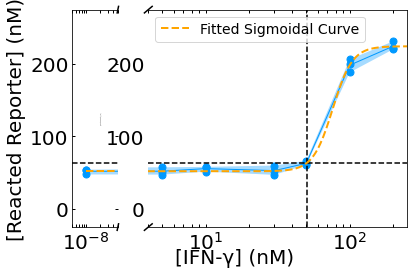

Fixed parameters: A = 51.99361244, B = 224.4899023
Fitted parameter C: 76.27 ± 1.84
Fitted parameter D: 6.37 ± 0.50
LOD: 50.32 ± 2.05


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import math
from scipy.stats import t

# Plot settings
lw = 2
fs = 20

'''Code to fit a Sigmoidal dose-response curve to Figure 5e'''


# Load the data
data = pd.read_excel('Figure5f.xlsx')
data_plot = data.loc[:, 'IFN-C-100-O1_1':'IFN-C-30-O1_Avg+stdev']
protein = data['[IFN]']

# Create the subplots with gridspec
fig = plt.figure(facecolor='w')
gs = GridSpec(1, 2, width_ratios=[0.15, 0.85])  # Adjust the width ratios as needed

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax)

# Plot data on ax
ax.plot(protein,data_plot['IFN-C-100-O1_Avg'], marker='o', color = (0, 0.6, 1), 
         markerfacecolor=(0,0.6,1),linewidth=1,markersize=0, label = 'Experiment')
ax.plot(protein,data_plot['IFN-C-100-O1_1'], marker='o', color = (0, 0.6,1), 
         markerfacecolor=(0,0.6,1),linewidth=0,markersize=7)
ax.plot(protein,data_plot['IFN-C-100-O1_2'], marker='o', color = (0, 0.6, 1), 
         markerfacecolor=(0,0.6,1),linewidth=0,markersize=7)
ax.plot(protein,data_plot['IFN-C-100-O1_3'], marker='o', color = (0, 0.6, 1), 
         markerfacecolor=(0,0.6,1),linewidth=0,markersize=7)
ax2.plot(protein,data_plot['IFN-C-100-O1_Avg'], marker='o', color = (0, 0.6, 1), 
         markerfacecolor=(0,0.6,1),linewidth=1,markersize=0)
ax2.plot(protein,data_plot['IFN-C-100-O1_1'], marker='o', color = (0, 0.6,1), 
         markerfacecolor=(0,0.6,1),linewidth=0,markersize=7)
ax2.plot(protein,data_plot['IFN-C-100-O1_2'], marker='o', color = (0, 0.6, 1), 
         markerfacecolor=(0,0.6,1),linewidth=0,markersize=7)
ax2.plot(protein,data_plot['IFN-C-100-O1_3'], marker='o', color = (0, 0.6, 1), 
         markerfacecolor=(0,0.6,1),linewidth=0,markersize=7)

ax.fill_between(protein, data_plot['IFN-C-100-O1_Min'],  data_plot['IFN-C-100-O1_Max'], color=(0,0.6,1), alpha=0.35, linewidth = 0, interpolate=True)
ax2.fill_between(protein, data_plot['IFN-C-100-O1_Min'],  data_plot['IFN-C-100-O1_Max'], color=(0,0.6,1), alpha=0.35, linewidth = 0, interpolate=True)



# Modified sigmoidal function (4PL model) with fixed A and B

L = np.array([0.000000000001  ,5  ,10  ,30 ,50  ,100 , 200])

# A and B are determined from empirical results
A = 51.99361244 # min Reacted reporter concentration
B = 224.4899023 # max Reacted reporter concentration

def sigmoid(x, C, D):
    # C = fitted value - EC50 value
    # D = fitted value - slope of the point of inflection
    return A + (B - A) / (1 + (x / C)**-D)

# Initial guesses for parameters [C, D]
initial_guesses = [90, 10]

# Perform sigmoidal regression (fit the 4PL model with fixed A and B)
popt, pcov = curve_fit(sigmoid, L, data_plot['IFN-C-100-O1_Avg'], p0=initial_guesses, bounds=(0, np.inf))
C_fit, D_fit = popt

# Generate fitted curve
L_fit = np.logspace(-8, 2.4, 1000)
Reporter_fit = sigmoid(L_fit, *popt)

# Standard errors of the parameters
perr = np.sqrt(np.diag(pcov))

# Confidence intervals
C_fit_ci = 1.96 * perr[0]
D_fit_ci = 1.96 * perr[1]

# Calculate LOD
y0 = 51.99361244
stdev0 = 3.803347275
y_LOD = y0 + 3 * stdev0

# Inverse function to find the corresponding concentration for y_LOD
def find_LOD(y_LOD, A, B, C, D):
    logLOD = np.log(C) - (1/D)*np.log(((B - y_LOD) / (y_LOD - A)))
    return 2.71828183**logLOD

LOD = find_LOD(y_LOD, A, B, C_fit, D_fit)

# Partial derivative of LOD with respect to C
dLOD_dC = ((B - y_LOD) / (y_LOD - A)) ** (1 / -D_fit)
# Partial derivative of LOD with respect to D
dLOD_dD = C_fit * (((B - y_LOD) / (y_LOD - A)) ** (1 / -D_fit)) * (-np.log((B - y_LOD) / (y_LOD - A)) / -D_fit**2)

# Calculate LOD error using error propagation formula
LOD_error = np.sqrt((C_fit_ci * dLOD_dC)**2 + (D_fit_ci * dLOD_dD)**2)

# Mark the LOD on the plot
ax.axhline(y=y_LOD, color='black', linestyle='--')
ax.axvline(x=LOD, color='black', linestyle='--')
ax2.axhline(y=y_LOD, color='black', linestyle='--')
ax2.axvline(x=LOD, color='black', linestyle='--')


# Plot the fitted curve
ax.plot(L_fit, Reporter_fit, '--', linewidth=2, color='orange', label='Fitted Sigmoidal Curve')
ax2.plot(L_fit, Reporter_fit, '--', linewidth=2, color='orange', label='Fitted Sigmoidal Curve')

# Set x-axis limits and scales
ax.set_xlim(0.000000005, 0.00000005)
ax2.set_xlim(4, 250)
ax.set_xscale('log')
ax2.set_xscale('log')
plt.ylim(-25, 275)

# Hide spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Set font size for y-axis label
ax.set_ylabel('[Reacted Reporter] (nM)', fontsize=fs)
ax2.set_ylabel('[Reacted Reporter] (nM)', fontsize=0)
ax.xaxis.set_tick_params(which='both', size=3, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=3, width=1, direction='in', right='on')
ax2.xaxis.set_tick_params(which='both', size=3, width=1, direction='in', top='on')
ax2.yaxis.set_tick_params(which='both', size=0, width=0, direction='in', right='on')

# plt.scatter(6.29,72.68620386, color = 'red')

# Set font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

# Add more ticks on the x-axis for ax2
ax2.set_xticks([10**n for n in range(1, 3)])  # Ticks at 10, 100, 1000, 10000
# ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Format ticks as integers

# Add the diagonal lines for broken axis effect
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Add a single, centered x-axis label
fig.text(0.5, 0.001, '[IFN-γ] (nM)', ha='center', fontsize=fs)

plt.legend(fontsize=fs-6)

# Show plot
# plt.savefig('060624_IFNC100O1_sigmoidfitting.svg')
plt.show()

# Print the fitted parameters
print(f"Fixed parameters: A = {A}, B = {B}")
print(f"Fitted parameter C: {C_fit:.2f} ± {C_fit_ci:.2f}")
print(f"Fitted parameter D: {D_fit:.2f} ± {D_fit_ci:.2f}")
print(f"LOD: {LOD:.2f} ± {LOD_error:.2f}")


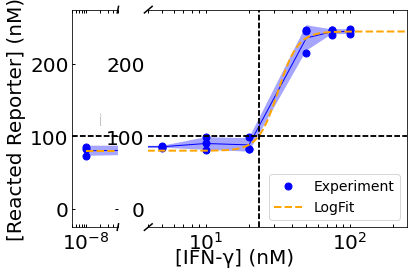

Fixed parameters: A = 80.32667306, B = 244.859475
Fitted parameter C: 31.85 ± 4.33
Fitted parameter D: 6.31 ± 1.87
LOD: 23.49 ± 3.83


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import scipy.optimize
import math
from scipy.stats import t

# Plot settings
lw = 2
fs = 20

'''Code to fit a Sigmoidal dose-response curve to Figure 5e'''


# Load the data
data = pd.read_excel('IFN-C-50-O1_steadystate.xlsx')
data_plot = data.loc[:, 'Trial 1':'Avg+Stdev']
protein = data['[IFN]']

# Create the subplots with gridspec
fig = plt.figure(facecolor='w')
gs = GridSpec(1, 2, width_ratios=[0.15, 0.85])  # Adjust the width ratios as needed

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax)

# Plot data on ax
ax.plot(protein, data_plot['Average'], marker='o', color=(0, 0, 1),
        markerfacecolor=(0, 0, 1), linewidth=1, markersize=0)
ax.plot(protein, data_plot['Trial 1'], marker='o', color=(0, 0, 1),
        markerfacecolor=(0, 0, 1), linewidth=0, markersize=7, label='Experiment')
ax.plot(protein, data_plot['Trial 2'], marker='o', color=(0, 0, 1),
        markerfacecolor=(0, 0, 1), linewidth=0, markersize=7)
ax.plot(protein, data_plot['Trial 3'], marker='o', color=(0, 0, 1),
        markerfacecolor=(0, 0, 1), linewidth=0, markersize=7)

# Plot data on ax2
ax2.plot(protein, data_plot['Average'], marker='o', color=(0, 0, 1),
         markerfacecolor=(0, 0, 1), linewidth=1, markersize=0)
ax2.plot(protein, data_plot['Trial 1'], marker='o', color=(0, 0, 1),
         markerfacecolor=(0, 0, 1), linewidth=0, markersize=7, label='Experiment')
ax2.plot(protein, data_plot['Trial 2'], marker='o', color=(0, 0, 1),
         markerfacecolor=(0, 0, 1), linewidth=0, markersize=7)
ax2.plot(protein, data_plot['Trial 3'], marker='o', color=(0, 0, 1),
         markerfacecolor=(0, 0, 1), linewidth=0, markersize=7)

ax.fill_between(protein, data_plot['Avg-Stdev'],  data_plot['Avg+Stdev'], color=(0,0,1), alpha=0.35, linewidth = 0, interpolate=True)
ax2.fill_between(protein, data_plot['Avg-Stdev'],  data_plot['Avg+Stdev'], color=(0,0,1), alpha=0.35, linewidth = 0, interpolate=True)


# Modified sigmoidal function (4PL model) with fixed A and B

L = np.array([0.000000000001  ,5  ,10  ,20 ,50  ,75 , 100])

# A and B are determined from empirical results
A = 80.32667306 # min Reacted reporter concentration
B = 244.859475 # max Reacted reporter concentration

def sigmoid(x, C, D):
#     C = # EC50 value
#     D = # slope of the point of inflection
    return A + (B - A) / (1 + (x / C)**-D)

# Initial guesses for parameters [C, D]
initial_guesses = [1, 1]

# Perform sigmoidal regression (fit the 4PL model with fixed A and B)
popt, pcov = curve_fit(sigmoid, L, data_plot['Average'], p0=initial_guesses, bounds=(0, np.inf))
C_fit, D_fit = popt

# Generate fitted curve
L_fit = np.logspace(-8, 4, 1000)
Reporter_fit = sigmoid(L_fit, *popt)

# Standard errors of the parameters
perr = np.sqrt(np.diag(pcov))

# Confidence intervals
C_fit_ci = 1.96 * perr[0]
D_fit_ci = 1.96 * perr[1]

# Calculate LOD
y0 = 80.32667306
stdev0 = 7.000402093
y_LOD = y0 + 3 * stdev0

# Inverse function to find the corresponding concentration for y_LOD
def find_LOD(y_LOD, A, B, C, D):
    logLOD = np.log(C) - (1/D)*np.log(((B - y_LOD) / (y_LOD - A)))
    return 2.71828183**logLOD

LOD = find_LOD(y_LOD, A, B, C_fit, D_fit)

# Partial derivative of LOD with respect to C
dLOD_dC = ((B - y_LOD) / (y_LOD - A)) ** (1 / -D_fit)
# Partial derivative of LOD with respect to D
dLOD_dD = C_fit * (((B - y_LOD) / (y_LOD - A)) ** (1 / -D_fit)) * (-np.log((B - y_LOD) / (y_LOD - A)) / -D_fit**2)

# Calculate LOD error using error propagation formula
LOD_error = np.sqrt((C_fit_ci * dLOD_dC)**2 + (D_fit_ci * dLOD_dD)**2)

# Mark the LOD on the plot
ax.axhline(y=y_LOD, color='black', linestyle='--')
ax.axvline(x=LOD, color='black', linestyle='--')
ax2.axhline(y=y_LOD, color='black', linestyle='--')
ax2.axvline(x=LOD, color='black', linestyle='--')

# Plot the fitted curve
ax.plot(L_fit, Reporter_fit, '--', linewidth=2, color='orange', label='LogFit')
ax2.plot(L_fit, Reporter_fit, '--', linewidth=2, color='orange', label='LogFit')

# Mark the LOD on the plot
ax.axhline(y=y_LOD, color='black', linestyle='--')
ax.axvline(x=LOD, color='black', linestyle='--')
ax2.axhline(y=y_LOD, color='black', linestyle='--')
ax2.axvline(x=LOD, color='black', linestyle='--')

# Set x-axis limits and scales
ax.set_xlim(0.000000005, 0.00000005)
ax2.set_xlim(4, 250)
ax.set_xscale('log')
ax2.set_xscale('log')
plt.ylim(-25, 275)

# Hide spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Set font size for y-axis label
ax.set_ylabel('[Reacted Reporter] (nM)', fontsize=fs)
ax2.set_ylabel('[Reacted Reporter] (nM)', fontsize=0)
ax.xaxis.set_tick_params(which='both', size=3, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=3, width=1, direction='in', right='on')
ax2.xaxis.set_tick_params(which='both', size=3, width=1, direction='in', top='on')
ax2.yaxis.set_tick_params(which='both', size=0, width=0, direction='in', right='on')

# plt.scatter(6.29,72.68620386, color = 'red')

# Set font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

# Add more ticks on the x-axis for ax2
ax2.set_xticks([10**n for n in range(1, 3)])  # Ticks at 10, 100, 1000, 10000
# ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Format ticks as integers

# Add the diagonal lines for broken axis effect
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Add a single, centered x-axis label
fig.text(0.5, 0.001, '[IFN-γ] (nM)', ha='center', fontsize=fs)

plt.legend(fontsize=fs-6)

# Show plot
# plt.savefig('060624_IFNC50O1_sigmoidfitting_sensitivity.svg')
plt.show()

# Print the fitted parameters
print(f"Fixed parameters: A = {A}, B = {B}")
print(f"Fitted parameter C: {C_fit:.2f} ± {C_fit_ci:.2f}")
print(f"Fitted parameter D: {D_fit:.2f} ± {D_fit_ci:.2f}")
print(f"LOD: {LOD:.2f} ± {LOD_error:.2f}")


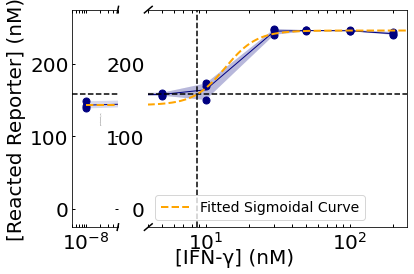

Fixed parameters: A = 143.2605197, B = 246.2021913
Fitted parameter C: 13.65 ± 3.29
Fitted parameter D: 3.95 ± 2.59
LOD: 8.72 ± 3.31


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import math
from scipy.stats import t

# Plot settings
lw = 2
fs = 20

'''Code to fit a Sigmoidal dose-response curve to Figure 5e'''


# Load the data
data = pd.read_excel('Figure5f.xlsx')
data_plot = data.loc[:, 'IFN-C-100-O1_1':'IFN-C-30-O1_Avg+stdev']
protein = data['[IFN]']

# Create the subplots with gridspec
fig = plt.figure(facecolor='w')
gs = GridSpec(1, 2, width_ratios=[0.15, 0.85])  # Adjust the width ratios as needed

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax)

# Plot data on ax
ax.plot(protein,data_plot['IFN-C-30-O1_Avg'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0,0,0.5),linewidth=1,markersize=0, label = 'Experiment')
ax.plot(protein,data_plot['IFN-C-30-O1_1'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0, 0, 0.5),linewidth=0,markersize=7)
ax.plot(protein,data_plot['IFN-C-30-O1_2'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0, 0, 0.5),linewidth=0,markersize=7)
ax.plot(protein,data_plot['IFN-C-30-O1_3'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0, 0, 0.5),linewidth=0,markersize=7)
plt.fill_between(protein, data_plot['IFN-C-30-O1_Min'],  data_plot['IFN-C-30-O1_Max'], color=(0,0,0.5), alpha=0.15, linewidth = 0, interpolate=True)
ax2.plot(protein,data_plot['IFN-C-30-O1_Avg'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0,0,0.5),linewidth=1,markersize=0)
ax2.plot(protein,data_plot['IFN-C-30-O1_1'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0, 0, 0.5),linewidth=0,markersize=7)
ax2.plot(protein,data_plot['IFN-C-30-O1_2'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0, 0, 0.5),linewidth=0,markersize=7)
ax2.plot(protein,data_plot['IFN-C-30-O1_3'], marker='o', color = (0, 0, 0.5), 
         markerfacecolor=(0, 0, 0.5),linewidth=0,markersize=7)
ax.fill_between(protein, data_plot['IFN-C-30-O1_Min'],  data_plot['IFN-C-30-O1_Max'], color=(0,0,0.5), alpha=0.15, linewidth = 0, interpolate=True)
ax2.fill_between(protein, data_plot['IFN-C-30-O1_Min'],  data_plot['IFN-C-30-O1_Max'], color=(0,0,0.5), alpha=0.15, linewidth = 0, interpolate=True)



# Modified sigmoidal function (4PL model) with fixed A and B

L = np.array([0.000000000001  ,5  ,10  ,30 ,50  ,100 , 200])

# A and B are determined from empirical results
A = 143.2605197 # min Reacted reporter concentration
B = 246.2021913 # max Reacted reporter concentration

def sigmoid(x, C, D):
    # C = fitted value - EC50 value
    # D = fitted value - slope of the point of inflection
    return A + (B - A) / (1 + (x / C)**-D)

# Initial guesses for parameters [C, D]
initial_guesses = [1, 1]

# Perform sigmoidal regression (fit the 4PL model with fixed A and B)
popt, pcov = curve_fit(sigmoid, L, data_plot['IFN-C-30-O1_Avg'], p0=initial_guesses, bounds=(0, np.inf))
C_fit, D_fit = popt

# Generate fitted curve
L_fit = np.logspace(-8, 2.4, 1000)
Reporter_fit = sigmoid(L_fit, *popt)

# Standard errors of the parameters
perr = np.sqrt(np.diag(pcov))

# Confidence intervals
C_fit_ci = 1.96 * perr[0]
D_fit_ci = 1.96 * perr[1]

# For digital sensors, we assume LOD ~ EC50

# Calculate LOD
y0 = 143.2605197
stdev0 = 4.997803598
y_LOD = y0 + 3 * stdev0

# Inverse function to find the corresponding concentration for y_LOD
def find_LOD(y_LOD, A, B, C, D):
    logLOD = np.log(C) - (1/D)*np.log(((B - y_LOD) / (y_LOD - A)))
    return 2.71828183**logLOD

LOD = find_LOD(y_LOD, A, B, C_fit, D_fit)

# Partial derivative of LOD with respect to C
dLOD_dC = ((B - y_LOD) / (y_LOD - A)) ** (1 / -D_fit)
# Partial derivative of LOD with respect to D
dLOD_dD = C_fit * (((B - y_LOD) / (y_LOD - A)) ** (1 / -D_fit)) * (-np.log((B - y_LOD) / (y_LOD - A)) / -D_fit**2)

# Calculate LOD error using error propagation formula
LOD_error = np.sqrt((C_fit_ci * dLOD_dC)**2 + (D_fit_ci * dLOD_dD)**2)

# Mark the LOD on the plot
ax.axhline(y=y_LOD, color='black', linestyle='--')
ax.axvline(x=LOD, color='black', linestyle='--')
ax2.axhline(y=y_LOD, color='black', linestyle='--')
ax2.axvline(x=LOD, color='black', linestyle='--')

# Plot the fitted curve
ax.plot(L_fit, Reporter_fit, '--', linewidth=2, color='orange', label='Fitted Sigmoidal Curve')
ax2.plot(L_fit, Reporter_fit, '--', linewidth=2, color='orange', label='Fitted Sigmoidal Curve')

# Set x-axis limits and scales
ax.set_xlim(0.000000005, 0.00000005)
ax2.set_xlim(4, 250)
ax.set_xscale('log')
ax2.set_xscale('log')
plt.ylim(-25, 275)

# Hide spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Set font size for y-axis label
ax.set_ylabel('[Reacted Reporter] (nM)', fontsize=fs)
ax2.set_ylabel('[Reacted Reporter] (nM)', fontsize=0)
ax.xaxis.set_tick_params(which='both', size=3, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=3, width=1, direction='in', right='on')
ax2.xaxis.set_tick_params(which='both', size=3, width=1, direction='in', top='on')
ax2.yaxis.set_tick_params(which='both', size=0, width=0, direction='in', right='on')

# plt.scatter(6.29,72.68620386, color = 'red')

# Set font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

# Add more ticks on the x-axis for ax2
ax2.set_xticks([10**n for n in range(1, 3)])  # Ticks at 10, 100, 1000, 10000
# ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Format ticks as integers

# Add the diagonal lines for broken axis effect
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Add a single, centered x-axis label
fig.text(0.5, 0.001, '[IFN-γ] (nM)', ha='center', fontsize=fs)

plt.legend(fontsize=fs-6)

# Show plot
# plt.savefig('060624_IFNC30O1_sigmoidfitting.svg')
plt.show()

# Print the fitted parameters
print(f"Fixed parameters: A = {A}, B = {B}")
print(f"Fitted parameter C: {C_fit:.2f} ± {C_fit_ci:.2f}")
print(f"Fitted parameter D: {D_fit:.2f} ± {D_fit_ci:.2f}")
print(f"LOD: {LOD:.2f} ± {LOD_error:.2f}")